# Ensemble Methods

## Imports

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#ANOVA
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

#evaluation
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Preprocessing
In this step, I will be converting categorical variables and performing feature selection.

In [2]:
bank = pd.read_csv('/Users/DELL/Desktop/Data Sci IOD/Capstone Project/bank-additional-full.csv', sep=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
bank.info

<bound method DataFrame.info of        age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact mo

## Data Transformation

### Label Encoding
Label encoding features that have an order or heirarchy.

In [5]:
bank['y'].replace({'yes':1,'no':0},inplace=True)
bank['education'].replace({'illiterate': 0, 'unknown': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4,
                           'high.school': 5, 'professional.course': 6, 'university.degree': 7,},inplace=True)
bank['month'].replace({'mar': 0, 'apr': 1, 'may': 2, 'jun': 3, 'jul': 4, 'aug': 5, 'sep': 6, 'oct': 7,
                      'nov': 8, 'dec': 9},inplace=True)
bank['day_of_week'].replace({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4},inplace=True)

### One Hot Encoding
Each categorical value is converted into a new categorical column and given a binary value of 1 or 0 by One Hot Encoder. A binary vector is used to represent each integer value. The index is denoted by a 1 and all values are zero.

In [6]:
bank_dummy = pd.get_dummies(data = bank, columns = ['job', 'loan', 'marital', 'default', 'housing', 
                                                    'contact', 'poutcome'], prefix = ['job', 'loan', 'marital', 'default', 'housing', 
                                                    'contact', 'poutcome'], drop_first=False)

In [7]:
bank_dummy.columns

Index(['age', 'education', 'month', 'day_of_week', 'duration', 'campaign',
       'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

## Feature Selection
The most significant characteristics are kept after SelectKBest scores the features against the target variable using a function. I will use "f_classif" as the scoring function as my features are primarily discrete values and I am working with a classification problem. The amount of features I want to have in the end, after the feature selection procedure is complete, is 10, so I've picked k = 10.

In [8]:
# ANOVA feature selection for numeric input and categorical output
Xf = bank_dummy.drop(['y', 'duration'], axis=1)
yf = bank_dummy['y']

# split into 80:20 ration
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size = 0.2, random_state = 0)

# Define feature selection
fs = SelectKBest(score_func=f_classif, k=10)

# Apply feature selection
Xf_selected = fs.fit_transform(Xf_train, yf_train)
print(Xf_selected.shape)
print(Xf_train.shape)

filter = fs.get_support(indices=True)

features = np.array(Xf_train.columns)
print(features[filter])

(32950, 10)
(32950, 42)
['pdays' 'previous' 'emp.var.rate' 'cons.price.idx' 'euribor3m'
 'nr.employed' 'contact_cellular' 'contact_telephone'
 'poutcome_nonexistent' 'poutcome_success']


## Oversampling: SMOTE
For oversampling, I'll employ the SMOTE technique. Nitesh Chawla, et al. described this method in their 2002 publication titled "SMOTE: Synthetic Minority Over-sampling Technique." 

SMOTE selects examples in the feature space that are close to one another, draws a line between the examples, and then creates a new sample at a location along the line. 

To be more precise, a random representative from the minority class is initially picked. Next, k nearest neighbours for that example are located (k is normally equal to 5). A synthetic example is made at a randomly chosen position in feature space between two instances and their randomly chosen neighbour.

"… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b."

— Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

In [9]:
#Defining feature and target variables
X = bank_dummy[['pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
                'nr.employed', 'contact_cellular', 'contact_telephone',
                'poutcome_nonexistent', 'poutcome_success']] #features obtained from feature selection step
y = bank_dummy['y']

# split into 80:20 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Applying SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [10]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) #yes
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) #no

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) #yes
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) #no

Before OverSampling, counts of label '1': 3721
Before OverSampling, counts of label '0': 29229 

After OverSampling, counts of label '1': 29229
After OverSampling, counts of label '0': 29229


# Modelling

## Decision Trees

In [11]:
#create model
dtclf = DecisionTreeClassifier(max_depth=15)

#fit model
dtclf.fit(X_train_res, y_train_res)

#evaluate 
print("Accuracy on training set: ", np.round(dtclf.score(X_train_res, y_train_res), 3))
print("Accuracy on test set: ", np.round(dtclf.score(X_test, y_test), 3))

Accuracy on training set:  0.7735126073420233
Accuracy on test set:  0.852998300558388


In [80]:
#classification report
y_pred = dtclf.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7319
           1       0.38      0.52      0.44       919

    accuracy                           0.85      8238
   macro avg       0.66      0.71      0.68      8238
weighted avg       0.87      0.85      0.86      8238



0.746


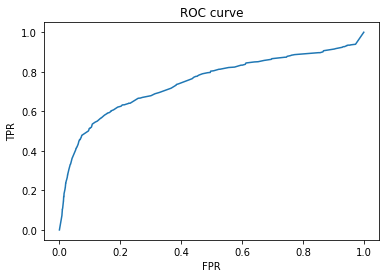

In [12]:
predict = dtclf.predict_proba(X_test)

print(np.round(roc_auc_score(y_test, predict[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### Visualising tree

In [13]:
#create
dtclf2 = DecisionTreeClassifier(max_depth=3, max_features=2, random_state=42)

#fit
dtclf2.fit(X_train_res, y_train_res)

#evaluate 
print("Accuracy on training set: ", dtclf2.score(X_train_res, y_train_res))
print("Accuracy on test set: ", dtclf2.score(X_test, y_test))

Accuracy on training set:  0.7184645386431284
Accuracy on test set:  0.716921582908473


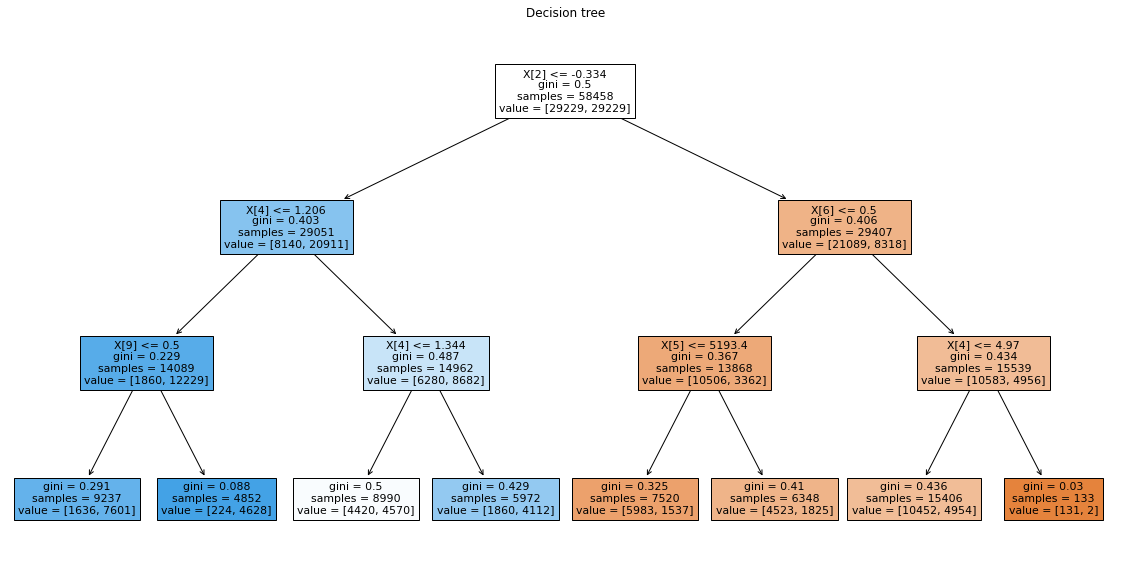

In [14]:
plt.figure(figsize=(20,10))
plot_tree(dtclf2, filled=True)
plt.title("Decision tree")
plt.show()

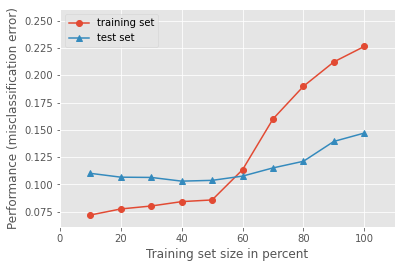

In [15]:
# plot learning curves dtclf
plt.figure()
plot_learning_curves(X_train_res, y_train_res, X_test, y_test, dtclf, print_model = False, style = 'ggplot')
plt.show()

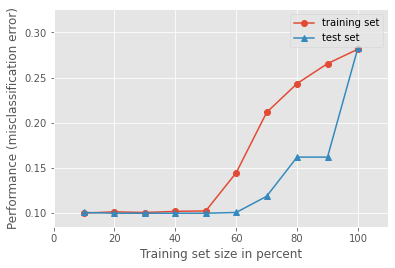

In [16]:
# plot learning curves - hypertuned to reduce overfitting dtclf2
plt.figure()
plot_learning_curves(X_train_res, y_train_res, X_test, y_test, dtclf2, print_model = False, style = 'ggplot')
plt.show()

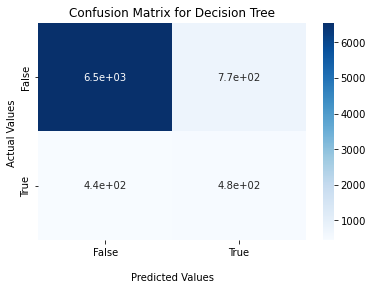

[[6549  770]
 [ 442  477]]


In [17]:
y_pred = dtclf.predict(X_test)
cf_matrix_dtclf = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix_dtclf, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Decision Tree');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# labeling
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

#show
plt.show()
print(cf_matrix_dtclf)

### Feature Importances

In [18]:
dtclf.feature_importances_

# 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
# 'nr.employed', 'contact_cellular', 'contact_telephone', 'poutcome_nonexistent', 'poutcome_success'

array([0.03240521, 0.0207041 , 0.13213071, 0.04574152, 0.21488984,
       0.52665196, 0.01083422, 0.01042099, 0.00529765, 0.00092378])

In [19]:
dtclf2.feature_importances_

array([0.        , 0.        , 0.76632543, 0.        , 0.20038153,
       0.00652941, 0.01178212, 0.        , 0.        , 0.01498151])

## Random Forests

In [46]:
%%time
#create
rfc = RandomForestClassifier()

#fit
rfc.fit(X_train_res, y_train_res)

#evaluate
#evaluate 
print("Accuracy on training set: ", round(rfc.score(X_train_res, y_train_res), 3))
print("Accuracy on test set: ", round(rfc.score(X_test, y_test), 3))

Accuracy on training set:  0.78
Accuracy on test set:  0.857
CPU times: user 2.17 s, sys: 18.5 ms, total: 2.19 s
Wall time: 2.19 s


In [81]:
#classification report
y_pred1 = rfc.predict(X_test)
cm1 = classification_report(y_test, y_pred1)
print(cm1)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7319
           1       0.39      0.50      0.44       919

    accuracy                           0.86      8238
   macro avg       0.66      0.70      0.68      8238
weighted avg       0.87      0.86      0.86      8238



n_estimators=100, criterion="entropy"
Accuracy on training set:  0.7802011700708201
Accuracy on test set:  0.8566399611556202

In [21]:
rfc.feature_importances_

array([0.05679817, 0.01919552, 0.13802436, 0.06474408, 0.40985586,
       0.24361215, 0.00726012, 0.02487597, 0.00774389, 0.02788987])

0.748


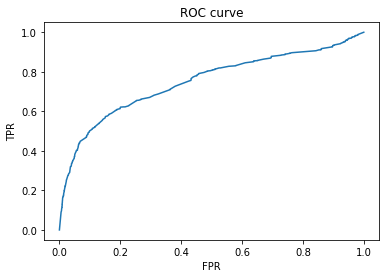

In [22]:
predict1 = rfc.predict_proba(X_test)

print(np.round(roc_auc_score(y_test, predict1[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict1[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

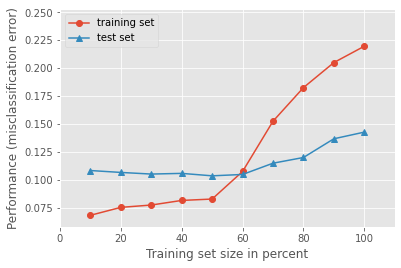

CPU times: user 12.1 s, sys: 85.6 ms, total: 12.2 s
Wall time: 12.2 s


In [23]:
%%time
# plot learning curves
plt.figure()
plot_learning_curves(X_train_res, y_train_res, X_test, y_test, rfc, 
                     print_model = False, style = 'ggplot')
plt.show()

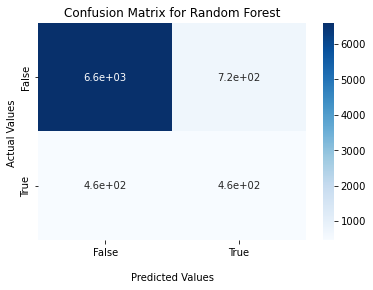

[[6549  770]
 [ 442  477]]


In [24]:
y_pred1 = rfc.predict(X_test)
cf_matrix_rfc = confusion_matrix(y_test, y_pred1)

ax = sns.heatmap(cf_matrix_rfc, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Random Forest');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# labeling
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

#show
plt.show()
print(cf_matrix_dtclf)

## Bagging - Bootstrap Aggregation

In [25]:
#Classification models
clf1 = DecisionTreeClassifier(max_depth = 3, max_features = 0.8)
clf2 = KNeighborsClassifier(n_neighbors = 3)
clf3 = GaussianNB()

bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging2 = BaggingClassifier(
    base_estimator = clf2,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging3 = BaggingClassifier(
    base_estimator = clf3,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)

In [48]:
%%time 

bagging1.fit(X_train_res, y_train_res)
bagging2.fit(X_train_res, y_train_res)
bagging3.fit(X_train_res, y_train_res)

print('Train set accuracy for bagging1: %.3f ' % bagging1.score(X_train_res, y_train_res))
print('Train set accuracy for bagging2: %.3f ' % bagging2.score(X_train_res, y_train_res))
print('Train set accuracy for bagging3: %.3f ' % bagging3.score(X_train_res, y_train_res))

print('Test set accuracy for bagging1: %.3f ' % bagging1.score(X_test, y_test))
print('Test set accuracy for bagging2: %.3f ' % bagging2.score(X_test, y_test))
print('Test set accuracy for bagging3: %.3f ' % bagging3.score(X_test, y_test))

Train set accuracy for bagging1: 0.740 
Train set accuracy for bagging2: 0.767 
Train set accuracy for bagging3: 0.686 
Test set accuracy for bagging1: 0.833 
Test set accuracy for bagging2: 0.828 
Test set accuracy for bagging3: 0.812 
CPU times: user 26.8 s, sys: 95.1 ms, total: 26.9 s
Wall time: 26.9 s


In [82]:
#classification report
y_pred2 = bagging1.predict(X_test)
cm2 = classification_report(y_test, y_pred2)
print(cm2)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7319
           1       0.35      0.61      0.45       919

    accuracy                           0.83      8238
   macro avg       0.65      0.73      0.67      8238
weighted avg       0.88      0.83      0.85      8238



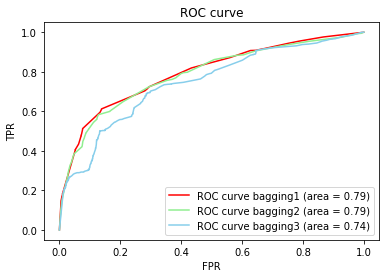

0.793
0.785
0.744


In [27]:
#plotting area
plt.figure(0).clf()

##bagging 1
predict2 = bagging1.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, predict2)

roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw = 1.5, label = 'ROC curve bagging1 (area = %0.2f)' % roc_auc)

##bagging2
predict3 = bagging2.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, predict3)

roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='lightgreen', lw = 1.5, label = 'ROC curve bagging2 (area = %0.2f)' % roc_auc)

##bagging3
predict4 = bagging3.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, predict4)

roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='skyblue', lw = 1.5, label = 'ROC curve bagging3 (area = %0.2f)' % roc_auc)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print(np.round(roc_auc_score(y_test, predict2), 3))
print(np.round(roc_auc_score(y_test, predict3), 3))
print(np.round(roc_auc_score(y_test, predict4), 3))

## AdaBoost

In [28]:
aclf1 = DecisionTreeClassifier(max_depth = 3, max_features = 0.8)
aclf2 = BernoulliNB()

boosting = AdaBoostClassifier(base_estimator = aclf1, n_estimators = 3)
boosting1 = AdaBoostClassifier(base_estimator = aclf2, n_estimators = 3)

In [49]:
%%time

boosting.fit(X_train_res, y_train_res)
boosting1.fit(X_train_res, y_train_res)

print('Train set accuracy for bagging1: %.3f ' % boosting.score(X_train_res, y_train_res))
print('Train set accuracy for bagging2: %.3f ' % boosting1.score(X_train_res, y_train_res))

print('Test set accuracy for bagging1: %.3f ' % boosting.score(X_test, y_test))
print('Test set accuracy for bagging2: %.3f ' % boosting1.score(X_test, y_test))

Train set accuracy for bagging1: 0.746 
Train set accuracy for bagging2: 0.689 
Test set accuracy for bagging1: 0.849 
Test set accuracy for bagging2: 0.658 
CPU times: user 273 ms, sys: 246 ms, total: 519 ms
Wall time: 226 ms


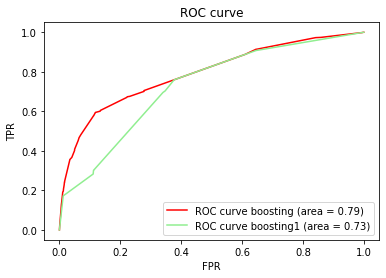

0.79
0.726


In [30]:
#plotting area
plt.figure(0).clf()

##boosting
predict5 = boosting.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, predict5)

roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw = 1.5, label = 'ROC curve boosting (area = %0.2f)' % roc_auc)

##bagging2
predict6 = boosting1.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, predict6)

roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='lightgreen', lw = 1.5, label = 'ROC curve boosting1 (area = %0.2f)' % roc_auc)


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

print(np.round(roc_auc_score(y_test, predict5), 3))
print(np.round(roc_auc_score(y_test, predict6), 3))

## XGBoost

Accuracy on training set: %.3f  0.7699544972458859
Accuracy on test set: %.3f  0.8540907987375577
[[6524  795]
 [ 407  512]]


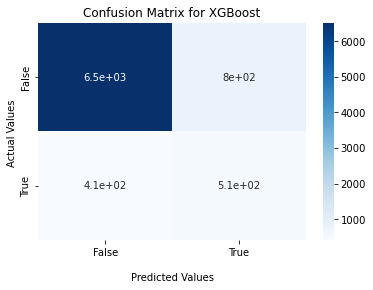

CPU times: user 12.2 s, sys: 1.91 s, total: 14.1 s
Wall time: 2.52 s


In [31]:
%%time

xboost = xgb.XGBClassifier()
xboost.fit(X_train_res, y_train_res)

print('Accuracy on training set: %.3f ', xboost.score(X_train_res, y_train_res))
print('Accuracy on test set: %.3f ', xboost.score(X_test, y_test))

# Predicting the Test set results
y_pred3 = xboost.predict(X_test)
 
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred3)
print(cm)
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for XGBoost');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# labeling
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

#show
plt.show()

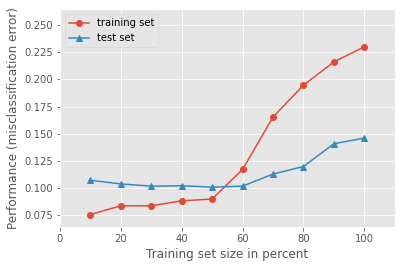

CPU times: user 1min 9s, sys: 11 s, total: 1min 20s
Wall time: 14.4 s


In [32]:
%%time
#Learning curve
plt.figure()
plot_learning_curves(X_train_res, y_train_res, X_test, y_test, 
                     xboost, print_model = False, style = 'ggplot')
plt.show()

0.789


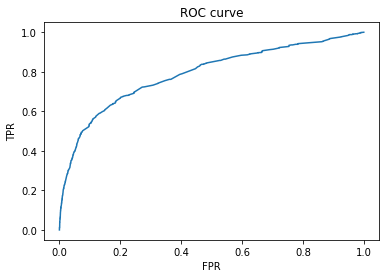

In [33]:
predict7 = xboost.predict_proba(X_test)

print(np.round(roc_auc_score(y_test, predict7[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict7[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Stacking

In [34]:
%%time

#define models
clf_1 = KNeighborsClassifier(n_neighbors = 2)
clf_2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf_3 = GaussianNB()
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
sclf = StackingClassifier(
    classifiers = [clf_1, clf_2, clf_3],
    meta_classifier = lr)

#fit
sclf.fit(X_train_res, y_train_res)

CPU times: user 4.25 s, sys: 215 ms, total: 4.47 s
Wall time: 3.93 s


StackingClassifier(classifiers=[KNeighborsClassifier(n_neighbors=2),
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=1),
                                GaussianNB()],
                   meta_classifier=LogisticRegression())

In [35]:
print('Accuracy on training set: %.3f ', sclf.score(X_train_res, y_train_res))
print('Accuracy on test set: %.3f ', sclf.score(X_test, y_test))

Accuracy on training set: %.3f  0.7789524102774642
Accuracy on test set: %.3f  0.8559116290361738


0.674


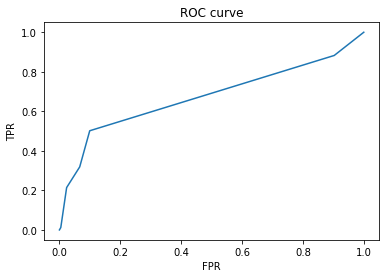

In [36]:
predict8 = sclf.predict_proba(X_test)

print(np.round(roc_auc_score(y_test, predict8[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict8[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Decision Tree with all features

In [37]:
##SMOTE
#Defining feature and target variables
X1 = bank_dummy[['age', 'education', 'month', 'day_of_week', 'campaign',
       'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success']] #features obtained from feature selection step
y1 = bank_dummy['y']

# split into 80:20 ration
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

#Applying SMOTE
sm1 = SMOTE(random_state = 2)
X_train_res1, y_train_res1 = sm1.fit_resample(X1_train, y1_train)

In [38]:
#create
dtclf3 = DecisionTreeClassifier(max_depth=10)

#fit
dtclf3.fit(X_train_res1, y_train_res1)

#evaluate 
print("Accuracy on training set: ", dtclf3.score(X_train_res1, y_train_res1))
print("Accuracy on test set: ", dtclf3.score(X1_test, y1_test))

Accuracy on training set:  0.8769372883095555
Accuracy on test set:  0.8759407623209516


In [39]:
dtclf3.feature_importances_

array([1.63882463e-02, 4.01051168e-03, 1.09451935e-01, 1.05692346e-02,
       5.68919251e-03, 5.76546419e-03, 1.53379932e-03, 3.91434633e-04,
       2.89158823e-02, 1.35747326e-02, 2.86522870e-02, 3.16009649e-01,
       3.20857827e-03, 5.74236938e-03, 1.16972558e-04, 3.34943155e-04,
       8.19709447e-04, 2.16414973e-04, 6.97675258e-05, 7.19862369e-03,
       0.00000000e+00, 4.72101097e-03, 3.98955888e-04, 2.51623051e-04,
       5.78212677e-03, 1.18411835e-02, 6.34987874e-03, 6.76920509e-02,
       1.24442578e-02, 2.20195196e-02, 2.60154040e-03, 1.01294091e-01,
       2.85750213e-02, 2.17751852e-04, 3.53504113e-02, 1.29773081e-02,
       3.80740193e-02, 3.18362317e-02, 3.49073488e-02, 1.67148318e-02,
       6.89248203e-03, 3.98607536e-04])

0.708


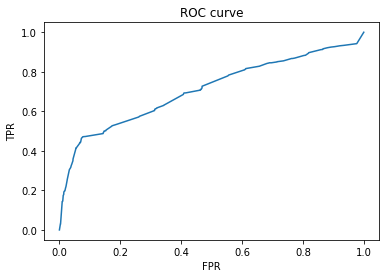

In [40]:
predict9 = dtclf3.predict_proba(X1_test)

print(np.round(roc_auc_score(y_test, predict9[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict9[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Decision tree with all features except the ones from obtained from feature selection

In [41]:
##SMOTE
#Defining feature and target variables
X2 = bank_dummy[['age', 'education', 'month', 'day_of_week', 'campaign',
       'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'loan_no', 'loan_unknown', 'loan_yes',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes']] #features obtained from feature selection step
y2 = bank_dummy['y']

# split into 80:20 ration
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

#Applying SMOTE
sm2 = SMOTE(random_state = 2)
X_train_res2, y_train_res2 = sm2.fit_resample(X2_train, y2_train)

In [42]:
#create
dtclf4 = DecisionTreeClassifier(max_depth=12)

#fit
dtclf4.fit(X_train_res2, y_train_res2)

#evaluate 
print("Accuracy on training set: ", dtclf4.score(X_train_res2, y_train_res2))
print("Accuracy on test set: ", dtclf4.score(X2_test, y2_test))

Accuracy on training set:  0.8405008724212255
Accuracy on test set:  0.8435299830055839


In [43]:
print(np.round(dtclf4.feature_importances_, 3))

[0.056 0.015 0.113 0.023 0.037 0.06  0.046 0.047 0.035 0.051 0.001 0.049
 0.04  0.    0.041 0.035 0.    0.013 0.004 0.012 0.017 0.009 0.019 0.
 0.065 0.128 0.    0.036 0.026 0.022]


0.663


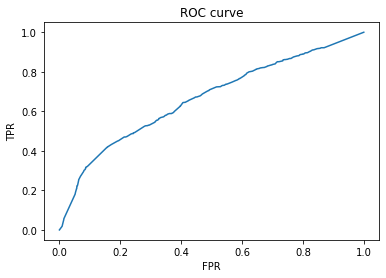

In [44]:
predict10 = dtclf4.predict_proba(X2_test)

print(np.round(roc_auc_score(y_test, predict10[:,1]), 3))

fpr, tpr, _ = roc_curve(y_test, predict10[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Model Evaluation
I'll be examining accuracy scores for overfitting and AUC as a metric for model evaluation. We now know that the dataset is imbalanced, with class "no" making up the majority. All of the models' accuracy scores are extremely similar, and they don't provide us with any useful insights into the data. By examining both the True Positive Rate (TPR) and False Positive Rate, AUC overcomes this issue. We will only obtain a good AUC if the TPR and FPR are both significantly higher than the ROC curve's random line.

In [60]:
test_score = [0.852, 0.857, 0.833, 0.828, 0.812, 0.849, 0.658, 0.854, 0.855]
model_name = ['DT', 'RF', 'Bagged DT', 'Bagged kNN', 'Bagged GNB', 'Boosted DT', 'Boosted BNB', 
              'XGBoost', 'Stacking']
  
# Create the pandas DataFrame with column name is provided explicitly
df_acc = pd.DataFrame(test_score, columns=['Accuracy'], index=model_name)
  
# print dataframe.
df_acc

,Accuracy
DT,0.852
RF,0.857
Bagged DT,0.833
Bagged kNN,0.828
Bagged GNB,0.812
Boosted DT,0.849
Boosted BNB,0.658
XGBoost,0.854
Stacking,0.855


Text(0, 0.5, 'Accuracy Score')

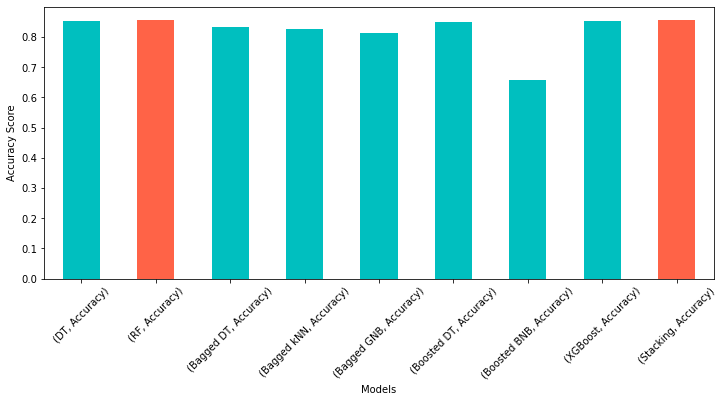

In [69]:
dfstacked = df_acc.stack()
mask = dfstacked <= 0.854

plt.figure(figsize=(12,5))
colors = np.array(['tomato']*len(dfstacked))
colors[mask.values] = 'c'

#df_acc['Accuracy'].plot(kind="bar")

dfstacked.plot(kind = 'bar', rot = 45, color = colors)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')

In [74]:
auc = [0.746, 0.748, 0.793, 0.785, 0.744, 0.790, 0.726, 0.789, 0.674]
model_name = ['DT', 'RF', 'Bagged DT', 'Bagged kNN', 'Bagged GNB', 'Boosted DT', 'Boosted BNB', 
              'XGBoost', 'Stacking']
  
# Create the pandas DataFrame with column name is provided explicitly
df_acc1 = pd.DataFrame(auc, columns=['AUC'], index=model_name)
  
# print dataframe.
df_acc1

,AUC
DT,0.746
RF,0.748
Bagged DT,0.793
Bagged kNN,0.785
Bagged GNB,0.744
Boosted DT,0.790
Boosted BNB,0.726
XGBoost,0.789
Stacking,0.674


Text(0, 0.5, 'Area Under Curve')

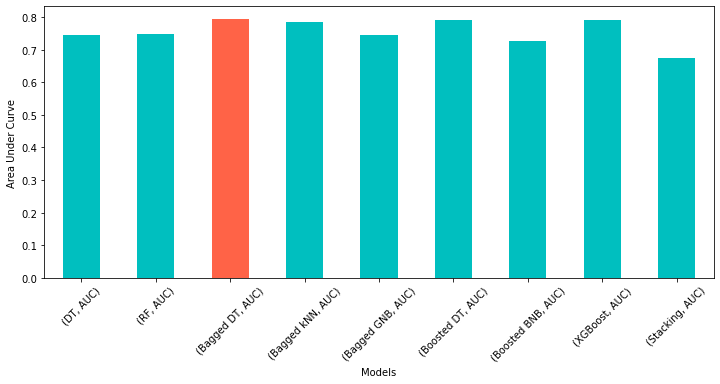

In [75]:
dfstacked1 = df_acc1.stack()
mask1 = dfstacked1 <= 0.79

plt.figure(figsize=(12,5))
colors = np.array(['tomato']*len(dfstacked1))
colors[mask1.values] = 'c'

#df_acc['Accuracy'].plot(kind="bar")

dfstacked1.plot(kind = 'bar', rot = 45, color = colors)
plt.xlabel('Models')
plt.ylabel('Area Under Curve')

# Conclusion

After testing and hypertuning a total of 11 models in this notebook and 14 for this project - I conclude that the best model for this dataset is "bagging1" (Bagged Decision Tree), with an accuracy score of 0.833 and an AUC of 0.793. Boosting (Boosted Decision Tree), which has an accuracy score of 0.849 and an AUC of 0.790, comes in second place.
Feature Selection raises and maintains the AUC score for most models. The accuracy of the two models created at the end of this notebook in sections 3.7 and 3.8 somewhat increases when all features are used, but the AUC score—our prefered evaluation metric—declines.